In [3]:
import pickle
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Charger les données CIFAR-10
train_data = []
train_labels = []

for i in range(1, 6):
    data_dict = unpickle(f'data_batch_{i}')
    if i == 1:
        train_data = data_dict[b'data']
        train_labels = data_dict[b'labels']
    else:
        train_data = np.vstack((train_data, data_dict[b'data']))
        train_labels = np.hstack((train_labels, data_dict[b'labels']))

test_dict = unpickle('test_batch')
test_data = test_dict[b'data']
test_labels = np.array(test_dict[b'labels'])

meta_dict = unpickle('batches.meta')
label_names = meta_dict[b'label_names']

train_data = train_data.reshape((len(train_data), 3, 32, 32)).transpose(0, 2, 3, 1)
train_data = train_data / 255.0
test_data = test_data.reshape((len(test_data), 3, 32, 32)).transpose(0, 2, 3, 1)
test_data = test_data / 255.0

# Diviser train_data en données étiquetées (5000) et non étiquetées (45000)
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(train_data, train_labels, train_size=5000, test_size=45000, random_state=42, stratify=train_labels)

# Supprimer les étiquettes des données non étiquetées
y_unlabeled = np.array([None] * len(x_unlabeled))

# Afficher les dimensions des données
print("Dimensions des données d'entraînement :", train_data.shape)
print("Dimensions des données de test :", test_data.shape)
print("Dimensions des données étiquetées :", x_labeled.shape)
print("Dimensions des données non étiquetées :", x_unlabeled.shape)

# Exemple d'affichage des premières étiquettes
print("Étiquettes des données étiquetées :", y_labeled[:10])
print("Étiquettes des données non étiquetées :", y_unlabeled[:10])

# Définir le modèle
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10)
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entraîner le modèle sur les données étiquetées
model.fit(x_labeled, y_labeled, epochs=20)

# Générer des pseudo-étiquettes pour les données non étiquetées
pseudo_labels = model.predict(x_unlabeled)
pseudo_labels = np.argmax(pseudo_labels, axis=1)

# Combiner les données étiquetées et les données non étiquetées avec les pseudo-étiquettes
x_combined = np.concatenate((x_labeled, x_unlabeled))
y_combined = np.concatenate((y_labeled.flatten(), pseudo_labels))

# Réentraîner le modèle sur le jeu de données combiné
history = model.fit(x_combined, y_combined, epochs=20, batch_size=64)

# Enregistrer l'historique d'entraînement
with open('history1.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Évaluer le modèle sur les données de test
loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Dimensions des données d'entraînement : (50000, 32, 32, 3)
Dimensions des données de test : (10000, 32, 32, 3)
Dimensions des données étiquetées : (5000, 32, 32, 3)
Dimensions des données non étiquetées : (45000, 32, 32, 3)
Étiquettes des données étiquetées : [4 7 7 3 7 1 2 1 8 1]
Étiquettes des données non étiquetées : [None None None None None None None None None None]
Epoch 1/20
157/157 [==============================] - 7s 15ms/step - loss: 2.4096 - accuracy: 0.2618
Epoch 2/20
157/157 [==============================] - 2s 13ms/step - loss: 1.8485 - accuracy: 0.3646
Epoch 3/20
157/157 [==============================] - 2s 13ms/step - loss: 1.6459 - accuracy: 0.4368
Epoch 4/20
157/157 [==============================] - 2s 15ms/step - loss: 1.4512 - accuracy: 0.4882
Epoch 5/20
157/157 [==============================] - 2s 13ms/step - loss: 1.2953 - accuracy: 0.5472
Epoch 6/20
157/157 [==============================] - 2s 13ms/step - loss: 1.1736 - accuracy: 0.5836
Epoch 7/20
157/157 [

313/313 [==============================] - 1s 3ms/step


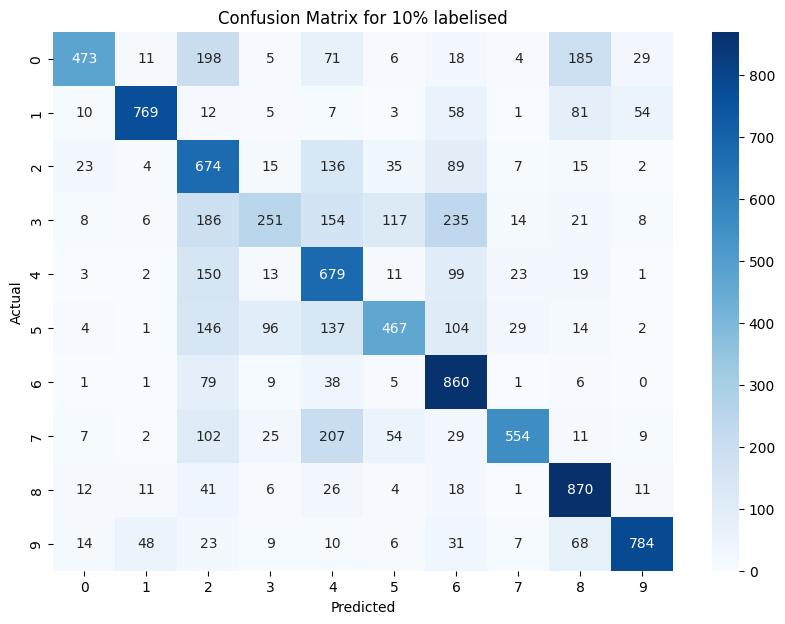

In [4]:
pred_labels = np.argmax(model.predict(test_data), axis=1)

cm = confusion_matrix(test_labels, pred_labels)

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(cm, 'Confusion Matrix for 10% labelised')